In [1]:
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed:
%autoreload 2

In [98]:
# General imports
from pathlib import Path
import numpy as np
import xarray as xr
from numbers import Number

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams["figure.figsize"] = (20, 10)


# power_perceiver imports
from power_perceiver.dataset import NowcastingDataset
from power_perceiver.consts import BatchKey
from power_perceiver.data_loader import HRVSatellite, PV
from power_perceiver.xr_batch_processor import SelectPVSystemsNearCenterOfImage
from power_perceiver.data_loader.data_loader import NumpyBatch



In [3]:
DATA_PATH = Path("~/dev/ocf/power_perceiver/data_for_testing/").expanduser()
assert DATA_PATH.exists()

In [4]:
dataset = NowcastingDataset(
    data_path=DATA_PATH,
    data_loaders=[HRVSatellite(), PV()],
    xr_batch_processors=[SelectPVSystemsNearCenterOfImage()],
)

In [5]:
BATCH_IDX = 0
np_batch = dataset[BATCH_IDX]

In [6]:
[key.value for key in np_batch.keys()]

['hrvsatellite',
 'hrvsatellite_time_utc',
 'hrvsatellite_x_osgb',
 'hrvsatellite_y_osgb',
 'pv',
 'pv_system_row_number',
 'pv_mask',
 'pv_time_utc',
 'pv_x_osgb',
 'pv_y_osgb']

In [56]:
%%time

def _get_min_per_example(coords_for_dim_from_all_modalities: dict[BatchKey, np.ndarray]) -> np.ndarray:
    n_modalities = len(coords_for_dim_from_all_modalities)
    assert n_modalities > 0
    batch_size = list(coords_for_dim_from_all_modalities.values())[0].shape[0]

    # Pre-allocate arrays to hold min values for each example of each modality's coordinates.
    mins = np.full((batch_size, n_modalities), fill_value=np.NaN, dtype=np.float32)

    for modality_i, coord_data_array in enumerate(coords_for_dim_from_all_modalities.values()):
        coord_data_array = coord_data_array.reshape((batch_size, -1))
        mins[:, modality_i] = np.nanmin(coord_data_array, axis=1)
        
    min_per_example = mins.min(axis=1)
    assert min_per_example.shape[0] == batch_size
    return np.expand_dims(min_per_example, axis=-1)


def _rescale_coords_for_single_dim_to_approx_0_to_1(
        coords_for_dim_from_all_modalities: dict[BatchKey, np.ndarray],
        length: Number,
    ) -> dict[str, np.ndarray]:
    """Rescale the coords for a single dimension, across all modalities.
    
    Args:
        length: The approximate length of the dimension across an example. For example,
            if the dimension is x_osgb then the length will be the distance in meters
            from the left to the right side of the example. Must be positive.
            
    Returns:
        Dictionary where the keys are "<BatchKey.value>_rescaled", and the values
        are a numpy array of the rescaled coords. The minimum value is guaranteed to be
        0 or larger. The maximum value will depend on the length.
    """
    assert length > 0
    min_per_example = _get_min_per_example(coords_for_dim_from_all_modalities)
    rescaled_arrays: dict[str, np.ndarray] = {}
    for key, array in coords_for_dim_from_all_modalities.items():
        if "satellite" in key.value and "time" not in key.value:
            # Handle 2-dimensional OSGB coords on the satellite imagery
            assert len(array.shape) == 3, f"Expected satellite coord to have 3 dims, not {len(array.shape)} {key.value=}"
            _min_per_example = np.expand_dims(min_per_example, axis=-1)
        else:
            _min_per_example = min_per_example
            
        rescaled_array = (array - _min_per_example) / length
        rescaled_arrays[f"{key.value}_rescaled"] = rescaled_array

    return rescaled_arrays


def _rescale_coords_for_all_dims_to_approx_0_to_1(
        np_batch: NumpyBatch,
        lengths: dict[str, Number],
    ) -> dict[str, np.ndarray]:
    """Rescale coords for all dimensions, across all modalities.
    
    Args:
        lengths: The approximate lengths of each dimension across an example. For example,
            if the dimension is x_osgb then the length will be the distance in meters
            from the left to the right side of the example. If the dimension is time_utc
            then the length is the total duration in seconds of the example.
            The keys must be x_osgb, y_osgb, or time_utc.
            We need to use constant lengths across all examples so the spatial encoding
            is always proportional to the "real world" length across all examples.
            If we didn't do that, a spatial encoding of 1 would represent different "real world"
            distances across examples. This would almost certainly be harmful, especially
            because we're expecting the model to learn to do some basic geometry!
    """
    rescaled_coords: dict[BatchKey, np.ndarray] = {}
    for dim_name in ("x_osgb", "y_osgb", "time_utc"):
        coords_for_dim_from_all_modalities: dict[BatchKey, np.ndarray] = {
            key: value.astype(np.float32) for key, value in np_batch.items() if key.value.endswith(dim_name)}
        length = lengths[dim_name]
        rescaled_coords_for_dim = _rescale_coords_for_single_dim_to_approx_0_to_1(
            coords_for_dim_from_all_modalities=coords_for_dim_from_all_modalities,
            length=length)
        rescaled_coords.update(rescaled_coords_for_dim)
    return rescaled_coords


rescaled_coords = _rescale_coords_for_all_dims_to_approx_0_to_1(
    np_batch=np_batch,
    lengths=dict(x_osgb=120_000, y_osgb=200_000, time_utc=60*5*31)
    )

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 1.98 ms


In [57]:
{key: np.nanmin(arr) for key, arr in rescaled_coords.items()}

{'hrvsatellite_x_osgb_rescaled': 0.0,
 'pv_x_osgb_rescaled': 0.18888229166666667,
 'hrvsatellite_y_osgb_rescaled': 0.0,
 'pv_y_osgb_rescaled': 0.02517484375,
 'hrvsatellite_time_utc_rescaled': 0.0,
 'pv_time_utc_rescaled': 0.0}

In [58]:
{key: np.nanmax(arr) for key, arr in rescaled_coords.items()}

{'hrvsatellite_x_osgb_rescaled': 0.8786345052083333,
 'pv_x_osgb_rescaled': 0.5974703125,
 'hrvsatellite_y_osgb_rescaled': 0.9128834375,
 'pv_y_osgb_rescaled': 0.7325675,
 'hrvsatellite_time_utc_rescaled': 0.9772043,
 'pv_time_utc_rescaled': 0.9772043}

In [49]:
# Next: Plot the original coords and the rescaled coords
550 - 450

100

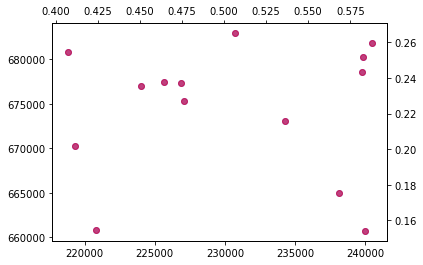

In [86]:
EXAMPLE_IDX = 0

osgb_ax = plt.axes()

osgb_ax.scatter(
    x=np_batch[BatchKey.pv_x_osgb][EXAMPLE_IDX],
    y=np_batch[BatchKey.pv_y_osgb][EXAMPLE_IDX],
    color="blue",
    alpha=0.5,
)

rescaled_ax = osgb_ax.twinx().twiny()

rescaled_ax.scatter(
    x=rescaled_coords['pv_x_osgb_rescaled'][EXAMPLE_IDX],
    y=rescaled_coords['pv_y_osgb_rescaled'][EXAMPLE_IDX],
    color="red", 
    alpha=0.5,
)

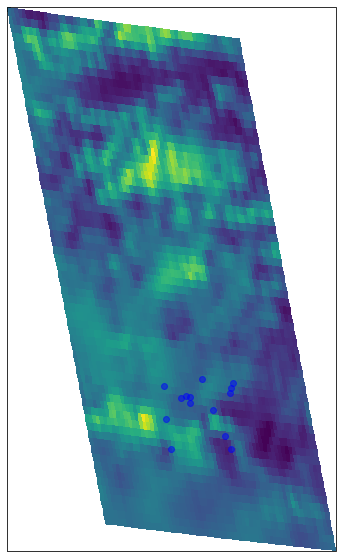

In [100]:

osgb_ax = plt.axes(projection=ccrs.OSGB(approx=False))

osgb_ax.pcolormesh(
    np_batch[BatchKey.hrvsatellite_x_osgb][EXAMPLE_IDX],
    np_batch[BatchKey.hrvsatellite_y_osgb][EXAMPLE_IDX],
    np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, 0, 0],   
)

osgb_ax.scatter(
    x=np_batch[BatchKey.pv_x_osgb][EXAMPLE_IDX],
    y=np_batch[BatchKey.pv_y_osgb][EXAMPLE_IDX],
    color="blue",
    alpha=0.5,
)

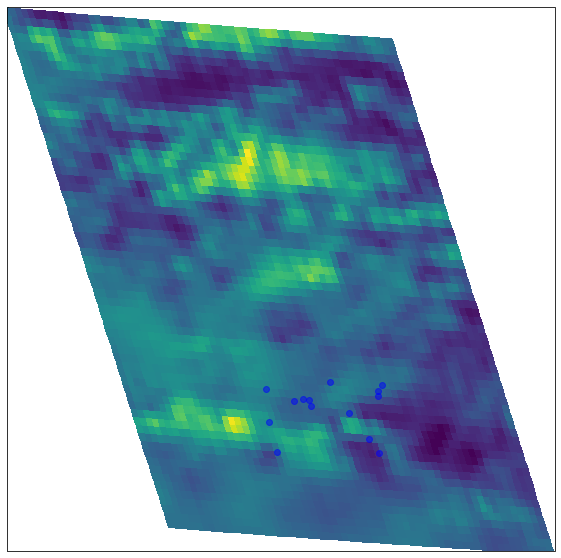

In [101]:
rescaled_axes = plt.axes(projection=ccrs.OSGB(approx=False))

rescaled_axes.pcolormesh(
    rescaled_coords["hrvsatellite_x_osgb_rescaled"][EXAMPLE_IDX],
    rescaled_coords["hrvsatellite_y_osgb_rescaled"][EXAMPLE_IDX],
    np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, 0, 0],   
)

rescaled_axes.scatter(
    x=rescaled_coords["pv_x_osgb_rescaled"][EXAMPLE_IDX],
    y=rescaled_coords["pv_y_osgb_rescaled"][EXAMPLE_IDX],
    color="blue",
    alpha=0.5,
)